In [1]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms as T
from tqdm import tqdm
import csv
from Generator.add_noise import add_noise
import os

In [2]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5]) 
])

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

In [3]:
import torch
import torch.nn as nn
import math

In [4]:
class NNDenoiser(nn.Module):
    def __init__(self, img_size=28, channels=1):
        super().__init__()
        self.input_dim = img_size * img_size * channels
        hidden = 4096
        
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, self.input_dim)
        )
        # self.time_embed = nn.Sequential(nn.Linear(hidden, hidden),
        #                                 nn.ReLU(),
        #                                 nn.Linear(hidden,self.input_dim))
        
        self.img_size = img_size
        self.channels = channels

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.input_dim // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.input_dim % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x,t):
        B = x.shape[0]
        x = x.view(B, -1)
        t = self.gen_t_embedding(t.view(B, -1))
        x = x + t.view(B, -1)
        x = self.net(x)
        x = x.view(B, self.channels, self.img_size, self.img_size)
        return x

In [5]:
for images, _ in train_loader:
    print(images.shape)
    break

torch.Size([64, 1, 28, 28])


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NNDenoiser().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
loss_fn = nn.MSELoss()

In [6]:
os.chdir("../")

In [8]:
log_file = "minist_artifacts/training_log_nn.csv"
if not os.path.exists(log_file):
    with open(log_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss"])

In [10]:
num_epochs = 100
best_val = float("inf")
patience = 5
counter = 0
for epoch in range(1,num_epochs+1):
    model.train()
    train_loss = 0
    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        images = images.to(device)
        B, C, H, W = images.shape
        K = 100

        # repeat images
        images = images.unsqueeze(1).repeat(1, K, 1, 1, 1)   # (B, K, C, H, W)
        images = images.view(B*K, C, H, W)

        # sample noise
        noise = torch.randn_like(images)

        # sample t
        t_int = torch.randint(0, 10000, (B*K, 1, 1, 1), device=device)
        t = t_int.float() / 10000.0

        xt = add_noise(images, t, noise)
        
        optimizer.zero_grad()

        pred_grad = model(xt, t_int)
        loss = ((pred_grad - (noise - images))**2).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= (len(train_loader.dataset)*K)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc=f"Epoch {epoch} [Val]"):
            images = images.to(device)
            B, C, H, W = images.shape
            K = 100

            # repeat images
            images = images.unsqueeze(1).repeat(1, K, 1, 1, 1)   # (B, K, C, H, W)
            images = images.view(B*K, C, H, W)

            # sample noise
            noise = torch.randn_like(images)

            # sample t
            t_int = torch.randint(0, 10000, (B*K, 1, 1, 1), device=device)
            t = t_int.float() / 10000.0

            xt = add_noise(images, t, noise)

            pred_grad = model(xt, t_int)
            loss = ((pred_grad - (noise - images))**2).mean()
            #loss = loss_fn(pred_grad, noise - images)
            val_loss += loss.item() * images.size(0)

    val_loss /= (len(test_loader.dataset)*K)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    # log CSV
    with open(log_file, mode="a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, val_loss])

    # save checkpoint 
    torch.save(model.state_dict(), f"minist_artifacts/model_{epoch}.pt")

Epoch 1 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.47it/s]


Epoch 2: Train Loss = 1.1292, Val Loss = 1.1262


Epoch 2 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.48it/s]


Epoch 3: Train Loss = 1.1263, Val Loss = 1.1238


Epoch 3 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.80it/s]


Epoch 4: Train Loss = 1.1239, Val Loss = 1.1219


Epoch 4 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.49it/s] 


Epoch 5: Train Loss = 1.1220, Val Loss = 1.1191


Epoch 5 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.77it/s]


Epoch 6: Train Loss = 1.1199, Val Loss = 1.1176


Epoch 6 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.74it/s]


Epoch 7: Train Loss = 1.1183, Val Loss = 1.1168


Epoch 7 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.60it/s]


Epoch 8: Train Loss = 1.1168, Val Loss = 1.1169


Epoch 8 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.62it/s]


Epoch 9: Train Loss = 1.1153, Val Loss = 1.1142


Epoch 9 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.45it/s] 


Epoch 10: Train Loss = 1.1137, Val Loss = 1.1118


Epoch 10 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.21it/s]


Epoch 11: Train Loss = 1.1124, Val Loss = 1.1114


Epoch 11 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.89it/s] 


Epoch 12: Train Loss = 1.1114, Val Loss = 1.1091


Epoch 12 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.78it/s]


Epoch 13: Train Loss = 1.1101, Val Loss = 1.1087


Epoch 13 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.61it/s]


Epoch 14: Train Loss = 1.1089, Val Loss = 1.1073


Epoch 14 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.18it/s]


Epoch 15: Train Loss = 1.1079, Val Loss = 1.1076


Epoch 15 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.21it/s] 


Epoch 16: Train Loss = 1.1069, Val Loss = 1.1054


Epoch 16 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.18it/s]


Epoch 17: Train Loss = 1.1060, Val Loss = 1.1038


Epoch 17 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.56it/s]


Epoch 18: Train Loss = 1.1050, Val Loss = 1.1038


Epoch 18 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.97it/s]


Epoch 19: Train Loss = 1.1043, Val Loss = 1.1035


Epoch 19 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.14it/s]


Epoch 20: Train Loss = 1.1034, Val Loss = 1.1026


Epoch 20 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.72it/s]


Epoch 21: Train Loss = 1.1027, Val Loss = 1.1014


Epoch 21 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.07it/s] 


Epoch 22: Train Loss = 1.1019, Val Loss = 1.1000


Epoch 22 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.06it/s]


Epoch 23: Train Loss = 1.1013, Val Loss = 1.1011


Epoch 23 [Val]: 100%|██████████| 157/157 [00:01<00:00, 90.94it/s]


Epoch 24: Train Loss = 1.1006, Val Loss = 1.0999


Epoch 24 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.76it/s]


Epoch 25: Train Loss = 1.1001, Val Loss = 1.0984


Epoch 25 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.46it/s]


Epoch 26: Train Loss = 1.0995, Val Loss = 1.0986


Epoch 26 [Val]: 100%|██████████| 157/157 [00:01<00:00, 91.19it/s]


Epoch 27: Train Loss = 1.0988, Val Loss = 1.0986


Epoch 27 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.81it/s]


Epoch 28: Train Loss = 1.0986, Val Loss = 1.0969


Epoch 28 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.25it/s] 


Epoch 29: Train Loss = 1.0980, Val Loss = 1.0970


Epoch 29 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.28it/s] 


Epoch 30: Train Loss = 1.0976, Val Loss = 1.0967


Epoch 30 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.95it/s]


Epoch 31: Train Loss = 1.0970, Val Loss = 1.0954


Epoch 31 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.78it/s]


Epoch 32: Train Loss = 1.0967, Val Loss = 1.0952


Epoch 32 [Val]: 100%|██████████| 157/157 [00:01<00:00, 90.94it/s]


Epoch 33: Train Loss = 1.0962, Val Loss = 1.0955


Epoch 33 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.63it/s]


Epoch 34: Train Loss = 1.0960, Val Loss = 1.0956


Epoch 34 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.60it/s]


Epoch 35: Train Loss = 1.0958, Val Loss = 1.0952


Epoch 35 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.58it/s]


Epoch 36: Train Loss = 1.0954, Val Loss = 1.0954


Epoch 36 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.39it/s]


Epoch 37: Train Loss = 1.0924, Val Loss = 1.0913


Epoch 37 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.21it/s]


Epoch 38: Train Loss = 1.0922, Val Loss = 1.0908


Epoch 38 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.40it/s]


Epoch 39: Train Loss = 1.0920, Val Loss = 1.0907


Epoch 39 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.75it/s]


Epoch 40: Train Loss = 1.0918, Val Loss = 1.0908


Epoch 40 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.58it/s] 


Epoch 41: Train Loss = 1.0916, Val Loss = 1.0905


Epoch 41 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.74it/s]


Epoch 42: Train Loss = 1.0916, Val Loss = 1.0910


Epoch 42 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.28it/s]


Epoch 43: Train Loss = 1.0914, Val Loss = 1.0902


Epoch 43 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.60it/s]


Epoch 44: Train Loss = 1.0913, Val Loss = 1.0906


Epoch 44 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.79it/s]


Epoch 45: Train Loss = 1.0912, Val Loss = 1.0905


Epoch 45 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.91it/s]


Epoch 46: Train Loss = 1.0910, Val Loss = 1.0903


Epoch 46 [Val]: 100%|██████████| 157/157 [00:01<00:00, 90.63it/s]


Epoch 47: Train Loss = 1.0909, Val Loss = 1.0900


Epoch 47 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.12it/s]


Epoch 48: Train Loss = 1.0908, Val Loss = 1.0900


Epoch 48 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.34it/s] 


Epoch 49: Train Loss = 1.0907, Val Loss = 1.0901


Epoch 49 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.98it/s]


Epoch 50: Train Loss = 1.0906, Val Loss = 1.0895


Epoch 50 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.23it/s]


Epoch 51: Train Loss = 1.0905, Val Loss = 1.0895


Epoch 51 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.23it/s]


Epoch 52: Train Loss = 1.0904, Val Loss = 1.0894


Epoch 52 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.54it/s]


Epoch 53: Train Loss = 1.0903, Val Loss = 1.0896


Epoch 53 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.70it/s] 


Epoch 54: Train Loss = 1.0902, Val Loss = 1.0891


Epoch 54 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.73it/s]


Epoch 55: Train Loss = 1.0900, Val Loss = 1.0885


Epoch 55 [Val]: 100%|██████████| 157/157 [00:01<00:00, 91.88it/s]


Epoch 56: Train Loss = 1.0899, Val Loss = 1.0891


Epoch 56 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.67it/s]


Epoch 57: Train Loss = 1.0898, Val Loss = 1.0890


Epoch 57 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.06it/s]


Epoch 58: Train Loss = 1.0896, Val Loss = 1.0892


Epoch 58 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.70it/s]


Epoch 59: Train Loss = 1.0896, Val Loss = 1.0889


Epoch 59 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.70it/s]


Epoch 60: Train Loss = 1.0880, Val Loss = 1.0870


Epoch 60 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.40it/s]


Epoch 61: Train Loss = 1.0879, Val Loss = 1.0869


Epoch 61 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.57it/s]


Epoch 62: Train Loss = 1.0878, Val Loss = 1.0868


Epoch 62 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.12it/s]


Epoch 63: Train Loss = 1.0876, Val Loss = 1.0866


Epoch 63 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.16it/s]


Epoch 64: Train Loss = 1.0876, Val Loss = 1.0866


Epoch 64 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.03it/s]


Epoch 65: Train Loss = 1.0875, Val Loss = 1.0872


Epoch 65 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.25it/s]


Epoch 66: Train Loss = 1.0875, Val Loss = 1.0864


Epoch 66 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.84it/s]


Epoch 67: Train Loss = 1.0873, Val Loss = 1.0865


Epoch 67 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.20it/s]


Epoch 68: Train Loss = 1.0872, Val Loss = 1.0865


Epoch 68 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.67it/s]


Epoch 69: Train Loss = 1.0872, Val Loss = 1.0864


Epoch 69 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.46it/s]


Epoch 70: Train Loss = 1.0871, Val Loss = 1.0862


Epoch 70 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.74it/s]


Epoch 71: Train Loss = 1.0871, Val Loss = 1.0865


Epoch 71 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.53it/s] 


Epoch 72: Train Loss = 1.0870, Val Loss = 1.0861


Epoch 72 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.55it/s]


Epoch 73: Train Loss = 1.0870, Val Loss = 1.0858


Epoch 73 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.87it/s]


Epoch 74: Train Loss = 1.0869, Val Loss = 1.0861


Epoch 74 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.90it/s]


Epoch 75: Train Loss = 1.0869, Val Loss = 1.0860


Epoch 75 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.26it/s] 


Epoch 76: Train Loss = 1.0868, Val Loss = 1.0860


Epoch 76 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.40it/s] 


Epoch 77: Train Loss = 1.0867, Val Loss = 1.0858


Epoch 77 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.28it/s] 


Epoch 78: Train Loss = 1.0859, Val Loss = 1.0851


Epoch 78 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.69it/s]


Epoch 79: Train Loss = 1.0857, Val Loss = 1.0848


Epoch 79 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.92it/s] 


Epoch 80: Train Loss = 1.0857, Val Loss = 1.0849


Epoch 80 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.07it/s]


Epoch 81: Train Loss = 1.0856, Val Loss = 1.0846


Epoch 81 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.42it/s]


Epoch 82: Train Loss = 1.0855, Val Loss = 1.0847


Epoch 82 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.13it/s]


Epoch 83: Train Loss = 1.0856, Val Loss = 1.0850


Epoch 83 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.46it/s]


Epoch 84: Train Loss = 1.0855, Val Loss = 1.0846


Epoch 84 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.18it/s]


Epoch 85: Train Loss = 1.0855, Val Loss = 1.0845


Epoch 85 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.93it/s] 


Epoch 86: Train Loss = 1.0854, Val Loss = 1.0845


Epoch 86 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.71it/s]


Epoch 87: Train Loss = 1.0853, Val Loss = 1.0845


Epoch 87 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.36it/s]


Epoch 88: Train Loss = 1.0854, Val Loss = 1.0842


Epoch 88 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.91it/s]


Epoch 89: Train Loss = 1.0852, Val Loss = 1.0844


Epoch 89 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.81it/s]


Epoch 90: Train Loss = 1.0852, Val Loss = 1.0843


Epoch 90 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.95it/s]


Epoch 91: Train Loss = 1.0852, Val Loss = 1.0842


Epoch 91 [Val]: 100%|██████████| 157/157 [00:01<00:00, 95.04it/s]


Epoch 92: Train Loss = 1.0852, Val Loss = 1.0842


Epoch 92 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.33it/s]


Epoch 93: Train Loss = 1.0846, Val Loss = 1.0837


Epoch 93 [Val]: 100%|██████████| 157/157 [00:01<00:00, 89.54it/s]


Epoch 94: Train Loss = 1.0847, Val Loss = 1.0835


Epoch 94 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.95it/s]


Epoch 95: Train Loss = 1.0846, Val Loss = 1.0838


Epoch 95 [Val]: 100%|██████████| 157/157 [00:01<00:00, 92.55it/s]


Epoch 96: Train Loss = 1.0846, Val Loss = 1.0836


Epoch 96 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.33it/s] 


Epoch 97: Train Loss = 1.0845, Val Loss = 1.0835


Epoch 97 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.07it/s]


Epoch 98: Train Loss = 1.0846, Val Loss = 1.0836


Epoch 98 [Val]: 100%|██████████| 157/157 [00:01<00:00, 94.93it/s]


Epoch 99: Train Loss = 1.0842, Val Loss = 1.0834


Epoch 99 [Val]: 100%|██████████| 157/157 [00:01<00:00, 93.62it/s]


Epoch 100: Train Loss = 1.0842, Val Loss = 1.0833


Epoch 100 [Val]: 100%|██████████| 157/157 [00:01<00:00, 96.83it/s] 


Epoch 101: Train Loss = 1.0842, Val Loss = 1.0833


In [10]:
def denormalize(x):
    # x in [-1, 1]
    return (x + 1) / 2

In [8]:
state_dict = torch.load("minist_artifacts/model_100.pt", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

NNDenoiser(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=784, bias=True)
  )
)

In [17]:
noise = torch.randn(1, 1, 28, 28).to(device)

In [9]:
pred = noise.squeeze(0)
image = denormalize(pred)
image = T.ToPILImage()(image.clamp(0,1))
image

In [18]:
I_0 = noise

In [12]:
def inference(I_0, t):
    pred = model(I_0, t)
    I_0 = I_0 - (1/1000)*pred
    return I_0

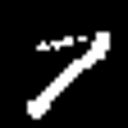

In [66]:
noise = torch.randn(1, 1, 28, 28).to(device)
I_0 = noise
for t in range(10000, -1, -1):
    I_0 = inference(I_0.to(device), torch.tensor(t-1).unsqueeze(0).to(device))

pred = I_0.squeeze(0)
image = denormalize(pred)
image = T.ToPILImage()(image.clamp(0,1))
image = image.resize((128,128))
image

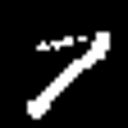

In [67]:
image_7 = image
image_7

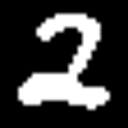

In [65]:
image_2 = image
image_2

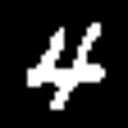

In [49]:
image_4 = image
image_4

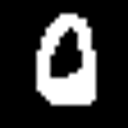

In [41]:
image_0 = image
image_0

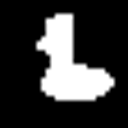

In [39]:
image_1 = image
image_1

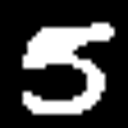

In [33]:
image_5 = image
image_5

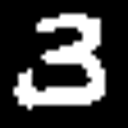

In [31]:
image_3 = image
image_3

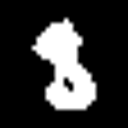

In [28]:
image_8 = image
image_8

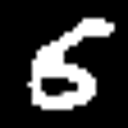

In [24]:
image_6  = image.resize((128,128))
image_6

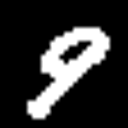

In [23]:
image_9 = image_9.resize((128,128))
image_9

In [68]:
IMAGES = [image_0, image_1, image_2, image_3, image_4, image_5, image_6, image_7, image_8, image_9]

In [70]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 12.7 MB/s  0:00:00 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 13.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


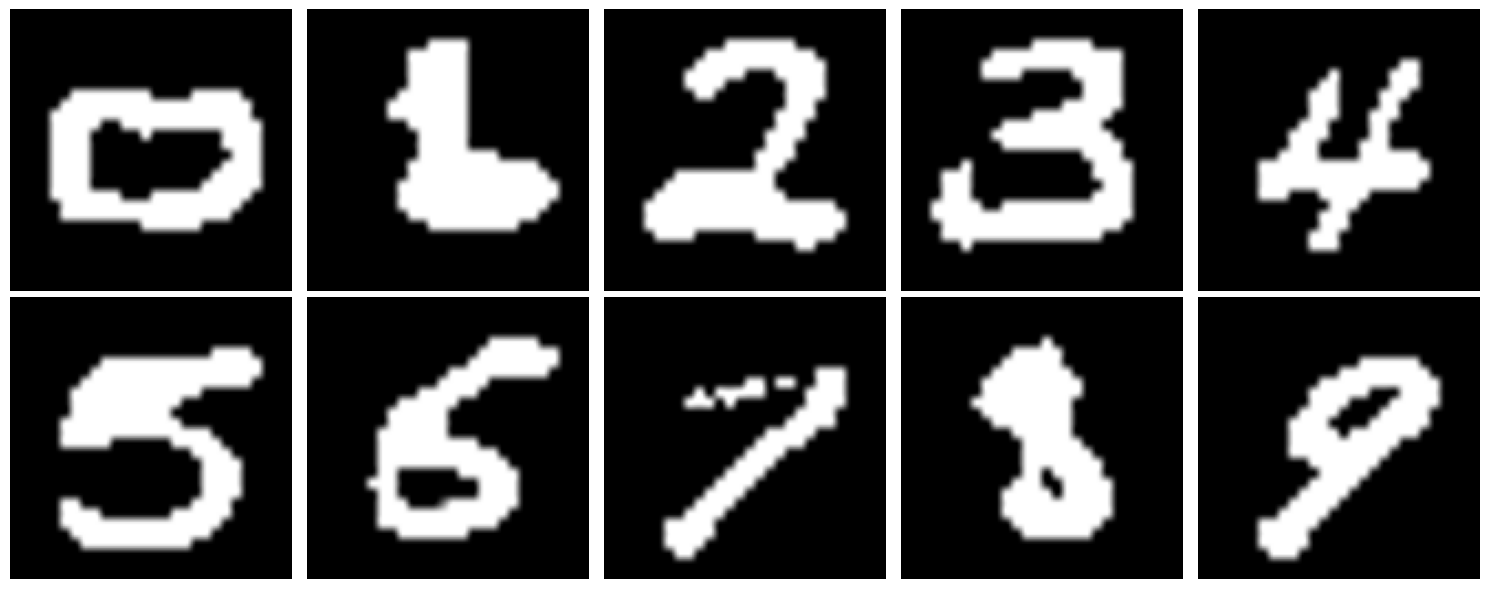

In [71]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(IMAGES[i], cmap="gray")  
    ax.axis("off")

plt.tight_layout()
plt.show()